# Messing Around with Different Machine Learning Models in R
## Logistic Regression

Different things to try with Logistic Regression
1. Using all variables to train the model - don't clean (except for removing the Cabin column)
2. Run the logistic regression example from r-bloggers to make sure we are getting the same results - https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/
2. Using only some predictors i.e. only the 2 strongest columns according to the logistic model
3. Compare accuracy to Azure ML - need to do randomForest - won't be logistic regression 
5. Look at distribution differences when the data is normalized/scaled and compare model that use scaled/normalized data between a model that doesn't
6. Look into cross validation

In [2]:
#Library imports
library(ggplot2)
library(dplyr)
library(grid)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
#Import data and prep
df <- read.csv(file = 'datasets/train.csv', stringsAsFactor = TRUE, na.strings = c("", NA))
head(df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


In [3]:
#remove Cabin column - too many missing values to infer
df <- df %>% select(-Cabin, -PassengerId, -Name, -Ticket)
head(df)
#check for missing values
sapply(df, function(x) sum(is.na(x)))

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22,1,0,7.2500,S
1,1,female,38,1,0,71.2833,C
1,3,female,26,0,0,7.9250,S
1,1,female,35,1,0,53.1000,S
0,3,male,35,0,0,8.0500,S
0,3,male,NA,0,0,8.4583,Q


Survived   Pclass      Sex      Age    SibSp    Parch     Fare Embarked 
       0        0        0      177        0        0        0        2

At this point, df contains several missing values in both the Age and Embarked columns. We want to know if the modeling function can handle missing values (like in Azure ML) or if we will have to fix our data. We attepmt to use the glm() model with this imperfect data

### 1. Modeling with Missing Values

In [4]:
#split data for training
train <- df[1:624, ]
test <- df[624:891,]

#build model
model <- glm(Survived ~. , family = binomial(link = "logit"), data = train)
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5319  -0.6993  -0.4081   0.6637   2.3737  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.395179   0.761617   7.084 1.40e-12 ***
Pclass      -1.161281   0.199152  -5.831 5.51e-09 ***
Sexmale     -2.569890   0.253866 -10.123  < 2e-16 ***
Age         -0.039385   0.009751  -4.039 5.37e-05 ***
SibSp       -0.334670   0.145759  -2.296   0.0217 *  
Parch        0.027597   0.156123   0.177   0.8597    
Fare        -0.002696   0.003232  -0.834   0.4042    
EmbarkedQ    0.136894   0.722154   0.190   0.8497    
EmbarkedS   -0.303114   0.320984  -0.944   0.3450    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 667.64  on 491  degrees of freedom
Residual deviance: 454.75  on 483  degrees of freedom
  (132 o

Now we assess the accuracy of our model

In [5]:
results <- predict(model, newdata = select(test, -Survived), type = 'response')
results <- ifelse(results > .5, 1, 0)
error <- mean(results != test$Survived)
print(paste("The model is ", error , " accurate"))

[1] "The model is  NA  accurate"


As we can see by our assessment prediction, the entire modeling process does not work with missing values. It is important to note though that our model still classifies and doesn't just crash entirely. Instead it simply returns NA if there were missing values for that specific row in test.

In [6]:
head(results)

624 625 626 627 628 629 
  0   0   0   0   1   0

We can see it did classify some rows, meaning it did not fail completely.

In [7]:
sum(is.na(results))

[1] 47

Scanning our results for NA values shows that 47 rows did not have predictions out of 267 rows. If we tell R to ignore the NA values in its accuracy assessment we get the following score.

In [8]:
error <- mean(results != test$Survived, na.rm = TRUE)
error

[1] 0.2081448

It appears our model was only 20% accurate, indicating a lot of work needs to be done still and that missing values should be scrubbed.

### 2. Logistic Regression From Example
Using the tutorial featured at, https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/ we test to see if we can reproduce their results

In [9]:
#load messy data
df <- read.csv(file = 'datasets/train.csv', na.strings = c("", NA))
#look at missing values
sapply(df, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0         687           2

In [10]:
#Look at different types of variables
sapply(df, function(x) class(x))

PassengerId    Survived      Pclass        Name         Sex         Age 
  "integer"   "integer"   "integer"    "factor"    "factor"   "numeric" 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
  "integer"   "integer"    "factor"   "numeric"    "factor"    "factor"

In [11]:
#look at number of different values by each column
sapply(df, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
        891           2           3         891           2          89 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           7         681         248         148           4

Cabin has so many missing values we will drop Cabin altogether because it would be too difficult to impute the Cabin. PassengerId is useless as it is just an identifier so we drop it as well. The same occurs with Ticket and Name

In [12]:
df <- df %>% select(-Cabin, -PassengerId, -Ticket, -Name)
head(df)

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22,1,0,7.2500,S
1,1,female,38,1,0,71.2833,C
1,3,female,26,0,0,7.9250,S
1,1,female,35,1,0,53.1000,S
0,3,male,35,0,0,8.0500,S
0,3,male,NA,0,0,8.4583,Q


In [13]:
#fix missing age values with the mean age
meanAge <- mean(df$Age, na.rm = TRUE)
df$Age[is.na(df$Age)] <- meanAge
head(df)

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.00000,1,0,7.2500,S
1,1,female,38.00000,1,0,71.2833,C
1,3,female,26.00000,0,0,7.9250,S
1,1,female,35.00000,1,0,53.1000,S
0,3,male,35.00000,0,0,8.0500,S
0,3,male,29.69912,0,0,8.4583,Q


In [14]:
contrasts(df$Sex)
contrasts(df$Embarked)

,male
female,0
male,1


,Q,S
C,0,0
Q,1,0
S,0,1


In [15]:
#remove the rows with NA values for embarked - there were 2
df <- df %>% filter(complete.cases(Embarked))
dim(df)
#check situation of missing values
sapply(df, function(x) sum(is.na(x)))

[1] 889   8

Survived   Pclass      Sex      Age    SibSp    Parch     Fare Embarked 
       0        0        0        0        0        0        0        0

As we can see above, there are no longer any missing data values

Now we move onto modeling. First we will split our data

In [16]:
train <- df[1:800, ]
test <- df[801:889, ]

Then we build our model

In [17]:
model <- glm(Survived ~., family = binomial(link = 'logit'), data = train)
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6064  -0.5954  -0.4254   0.6220   2.4165  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.137627   0.594998   8.635  < 2e-16 ***
Pclass      -1.087156   0.151168  -7.192 6.40e-13 ***
Sexmale     -2.756819   0.212026 -13.002  < 2e-16 ***
Age         -0.037267   0.008195  -4.547 5.43e-06 ***
SibSp       -0.292920   0.114642  -2.555   0.0106 *  
Parch       -0.116576   0.128127  -0.910   0.3629    
Fare         0.001528   0.002353   0.649   0.5160    
EmbarkedQ   -0.002656   0.400882  -0.007   0.9947    
EmbarkedS   -0.318786   0.252960  -1.260   0.2076    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1065.39  on 799  degrees of freedom
Residual deviance:  709.39  on 791  degrees of freedom
AIC: 7

Analyzing the model output, it appears SibSp, Parch, Fare, and Embarked are not statistically significant because their p-values are greater than .05. Of our statistically significant predictors, Sex has the lowest p-value, indicating it it is the strongest predictor of survival. Now we want to analyze the table of deviance so we run the anova() function on our model.

In [18]:
anova(model, test = 'Chisq')

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,799,1065.3922,NA
Pclass,1,83.6069449,798,981.7853,6.036064e-20
Sex,1,240.0135513,797,741.7717,3.906166e-54
Age,1,17.4946765,796,724.2770,2.881133e-05
SibSp,1,10.8423921,795,713.4346,9.920249e-04
Parch,1,0.8630972,794,712.5715,3.528734e-01
Fare,1,0.9942053,793,711.5773,3.187167e-01
Embarked,2,2.1873120,791,709.3900,3.349895e-01


Now that we have analyzed our model, it is time to test our model. Below we run our test data and count its accuracy

In [19]:
#predict and then score model
fitted.results <- predict(model, newdata = test %>% select(-Survived), type = 'response')
fitted.results <- ifelse(fitted.results > .5, 1, 0)
head(fitted.results)

801 802 803 804 805 806 
  1   1   0   0   0   0

In [20]:
# calculate error
error <- mean(fitted.results != test$Survived)
print(paste('Our logistical regression classifier is ', 1 - error, 'accurate or ', (1 - error) * 100, '% accurate'))

[1] "Our logistical regression classifier is  0.842696629213483 accurate or  84.2696629213483 % accurate"


This is the same accuracy as the website tutorial and we have verified the results

### 3. Using only some predictors

Looking at the previous model, we can identify which predictors provided the strongest correlation with survival rates. We are now going to see if only using some predictors instead of all variables can improve our performance.

In [21]:
#Reading/Tidying data to prepare for model
df <- read.csv(file = 'datasets/train_edited.csv', na.strings = c("", NA))
sapply(df, function(x) sum(is.na(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0           0 
      SibSp       Parch      Ticket        Fare    Embarked 
          0           0           0           0           0

Here we are only going to use the Pclass, Sex, and Age variables

In [22]:
df <- df %>% select(Survived, Pclass, Sex, Age)
train <- df[1:800, ]
test <- df[801:889, ]

In [23]:
model <- glm(Survived ~., family = binomial(link = 'logit'), data = train)
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6320  -0.6570  -0.4239   0.6420   2.4093  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.633935   0.472667   9.804  < 2e-16 ***
Pclass      -1.139026   0.125153  -9.101  < 2e-16 ***
Sexmale     -2.646164   0.197657 -13.388  < 2e-16 ***
Age         -0.031477   0.007724  -4.075  4.6e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1065.39  on 799  degrees of freedom
Residual deviance:  724.28  on 796  degrees of freedom
AIC: 732.28

Number of Fisher Scoring iterations: 4


In [24]:
anova(model, test = 'Chisq')

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,799,1065.3922,NA
Pclass,1,83.60694,798,981.7853,6.036064e-20
Sex,1,240.01355,797,741.7717,3.906166e-54
Age,1,17.49468,796,724.2770,2.881133e-05


All 3 predictors were statistically significant. Now we evaluate our model's accuracy with our test data

In [25]:
fitted.results <- predict(model, newdata = test %>% select(-Survived), type = 'response')
fitted.results <- ifelse(fitted.results > .5, 1, 0)
error <- mean(fitted.results != test$Survived)
print(paste('Our logistical regression classifier is ', 1 - error, 'accurate or ', (1 - error) * 100, '% accurate'))

[1] "Our logistical regression classifier is  0.797752808988764 accurate or  79.7752808988764 % accurate"


#### Conclusion
This model with less predictors was less accurate than our model with more predictors, an 85% vs 80% accuracy meaning the accuracy is rather close. 

### 4. Comparing with Azure ML and Logistic Regression
Looking at the Azure ML example using the preset logistic regression module and 90% of data for training, Azure ML's model was 79.8% accurate.

### 5. Normalizing Data
Here we explore the effects normalization has on our data. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


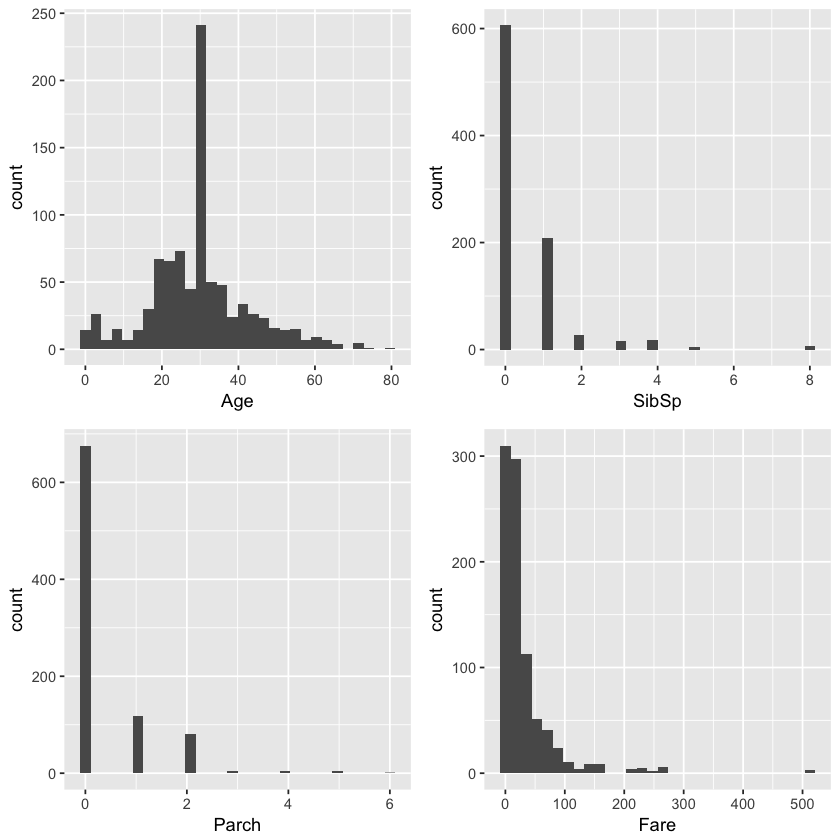

In [47]:
df <- read.csv(file = 'datasets/train_edited.csv')
df <- df %>% select(-PassengerId, -Name, -Ticket, -Sex, -Embarked, -Survived, -Pclass)
#normal output
p1 <- ggplot(df, aes(Age)) + geom_histogram()
p2 <- ggplot(df, aes(SibSp)) + geom_histogram()
p3 <- ggplot(df, aes(Parch)) + geom_histogram()
p4 <- ggplot(df, aes(Fare)) + geom_histogram()
grid.arrange(p1, p2, p3, p4, ncol = 2)
# columns <- sapply(df, is.numeric)
# df[columns] <- sapply(df[columns], scale)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


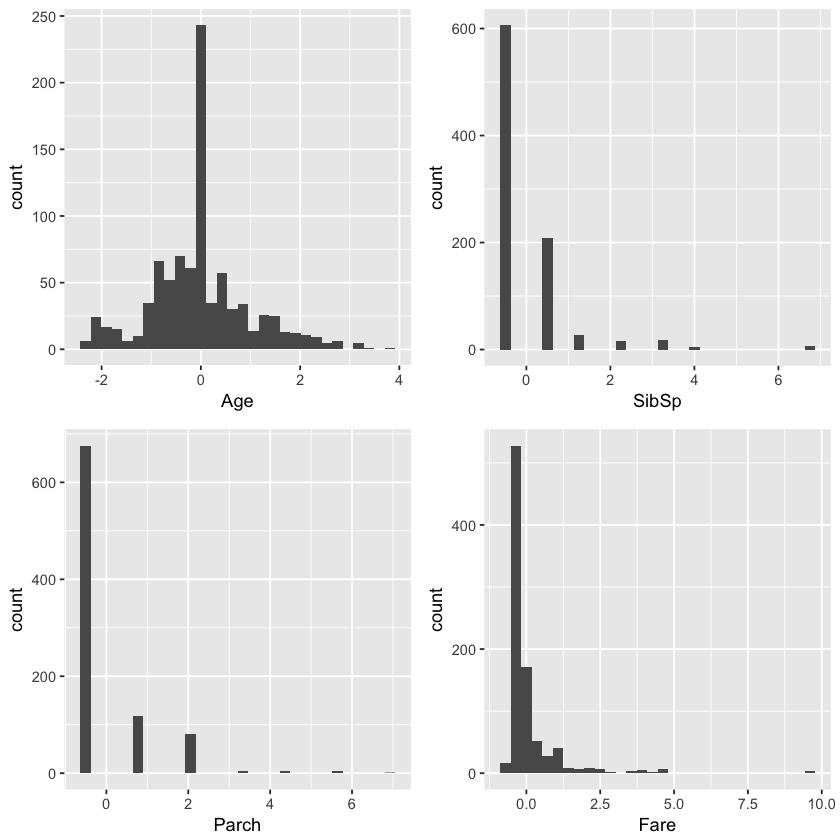

In [44]:
columns <- sapply(df, is.numeric)
df[columns] <- sapply(df[columns], scale)
p1 <- ggplot(df, aes(Age)) + geom_histogram()
p2 <- ggplot(df, aes(SibSp)) + geom_histogram()
p3 <- ggplot(df, aes(Parch)) + geom_histogram()
p4 <- ggplot(df, aes(Fare)) + geom_histogram()
grid.arrange(p1, p2, p3, p4, ncol = 2)

In [50]:
df <- read.csv('datasets/train_edited.csv')
df <- df %>% mutate(scaled_age = scale(Age), scaled_Fare = scale(Fare)) %>% select(-Fare, -Age)
#get rid of bad predictors
df <- df %>% select(-PassengerId, -Name, -Ticket)
head(df)

Survived,Pclass,Sex,SibSp,Parch,Embarked,scaled_age,scaled_Fare
0,3,male,1,0,S,-0.590162723,-0.4999583
1,1,female,1,0,C,0.643608719,0.7885028
1,3,female,0,0,S,-0.281719862,-0.4863762
1,1,female,1,0,S,0.412276574,0.4226232
0,3,male,0,0,S,0.412276574,-0.4838609
0,3,male,0,0,Q,0.003521745,-0.4756452


In [51]:
train <- df[1:800, ]
test <- df[801:889, ]

model <- glm(Survived ~., family = binomial(link = "logit"), data = train)
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6064  -0.5954  -0.4254   0.6220   2.4165  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.081579   0.434693   9.390  < 2e-16 ***
Pclass      -1.087156   0.151168  -7.192 6.40e-13 ***
Sexmale     -2.756819   0.212026 -13.002  < 2e-16 ***
SibSp       -0.292920   0.114642  -2.555   0.0106 *  
Parch       -0.116576   0.128127  -0.910   0.3629    
EmbarkedQ   -0.002656   0.400882  -0.007   0.9947    
EmbarkedS   -0.318786   0.252960  -1.260   0.2076    
scaled_age  -0.483298   0.106282  -4.547 5.43e-06 ***
scaled_Fare  0.075962   0.116960   0.649   0.5160    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1065.39  on 799  degrees of freedom
Residual deviance:  709.39  on 791  degrees of freedom
AIC: 7

In [53]:
scaled_results <- predict(model, newdata = test %>% select(-Survived), type = 'response')
scaled_results <- ifelse(scaled_results > .5, 1, 0)
error <- mean(scaled_results != test$Survived)
print(paste('Our logistical regression classifier is ', 1 - error, 'accurate or ', (1 - error) * 100, '% accurate'))

[1] "Our logistical regression classifier is  0.842696629213483 accurate or  84.2696629213483 % accurate"


Looking at the R-Blogger tutorial code in #2, both models produce the exact same accuracy of 84%, so in this case normalizing the data had no effect.

## 6. Cross Validation

In [22]:
library(caret)

In [23]:
df <- read.csv(file = 'datasets/train_edited.csv')
train_control <- trainControl(method = "cv", number = 10)
head(df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00000,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,S
6,0,3,"Moran, Mr. James",male,29.69912,0,0,330877,8.4583,Q


In [24]:
df <- df %>% select(-PassengerId, -Name, -Ticket)
df$Survived <- as.factor(df$Survived)
model <- train(Survived ~., data = df, trControl = train_control, method = 'glm', family = binomial(link = 'logit'))
model
confusionMatrix(model)
# sensitivity(model, df$Survived)
# specificity(model, df$Survived)

Generalized Linear Model 

889 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 800, 800, 801, 800, 800, 800, ... 
Resampling results:

  Accuracy   Kappa    
  0.7998212  0.5710206


Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction    0    1
         0 53.0 11.2
         1  8.8 27.0
                            
 Accuracy (average) : 0.7998


In [25]:
df <- read.csv(file = 'datasets/train_edited.csv', na.strings = c("", NA))
df <- df %>% select(-PassengerId, -Name, -Ticket)
train <- df[1:800, ]
test <- df[801:889, ]
model <- glm(Survived ~., family = binomial(link = 'logit'), data = train)
summary(model)
fitted.results <- predict(model, newdata = test %>% select(-Survived), type = 'response')
fitted.results <- ifelse(fitted.results > .5, 1, 0)
error <- mean(fitted.results != test$Survived)
print(paste('Our logistical regression classifier is ', 1 - error, 'accurate or ', (1 - error) * 100, '% accurate'))


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6064  -0.5954  -0.4254   0.6220   2.4165  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.137627   0.594998   8.635  < 2e-16 ***
Pclass      -1.087156   0.151168  -7.192 6.40e-13 ***
Sexmale     -2.756819   0.212026 -13.002  < 2e-16 ***
Age         -0.037267   0.008195  -4.547 5.43e-06 ***
SibSp       -0.292920   0.114642  -2.555   0.0106 *  
Parch       -0.116576   0.128127  -0.910   0.3629    
Fare         0.001528   0.002353   0.649   0.5160    
EmbarkedQ   -0.002656   0.400882  -0.007   0.9947    
EmbarkedS   -0.318786   0.252960  -1.260   0.2076    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1065.39  on 799  degrees of freedom
Residual deviance:  709.39  on 791  degrees of freedom
AIC: 7

[1] "Our logistical regression classifier is  0.842696629213483 accurate or  84.2696629213483 % accurate"


In [26]:
confusionMatrix(fitted.results, test$Survived)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 51  9
         1  5 24
                                          
               Accuracy : 0.8427          
                 95% CI : (0.7502, 0.9112)
    No Information Rate : 0.6292          
    P-Value [Acc > NIR] : 8.248e-06       
                                          
                  Kappa : 0.6543          
 Mcnemar's Test P-Value : 0.4227          
                                          
            Sensitivity : 0.9107          
            Specificity : 0.7273          
         Pos Pred Value : 0.8500          
         Neg Pred Value : 0.8276          
             Prevalence : 0.6292          
         Detection Rate : 0.5730          
   Detection Prevalence : 0.6742          
      Balanced Accuracy : 0.8190          
                                          
       'Positive' Class : 0               
                                          